# Apriori
This repository contains a basic implementation of the (randomized) Apriori algorithm for mining frequent item sets using the market-basket model. We compare the effectiveness and efficience of the two algorithms by running them on real data sets.

In [43]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [83]:
import requests
import time
import pandas as pd
import matplotlib.pyplot as plt

from src.apriori import apriori
from src.randomized_apriori import randomized_apriori

## 1. Load Data
First, let's load some testing data sets. The input format of the data is one line per basket, and each line contains the IDs of the items in the basket separated by space. We can assume that the IDs are 0,1,2,... More specifically, let's consider the following two data sets:
- *Retail*: A retail market basket dataset supplied by a anonymous Belgian retail supermarket store (small data set).
- *WebDocs*: A huge real-life transactional dataset built from a spidered collection of web html documents (huge data set).

We download these data sets from the web first.

In [3]:
execute_download: bool = False # change this line for download
if execute_download:
    # retails data set
    with open('./data/retail.dat.gz', 'wb') as outfile:
        content = requests.get('http://fimi.uantwerpen.be/data/retail.dat.gz', stream=True).content
        outfile.write(content)

    # webdocs data set
    with open('./data/webdocs.dat.gz', 'wb') as outfile:
        content = requests.get('http://fimi.uantwerpen.be/data/webdocs.dat.gz', stream=True).content
        outfile.write(content)

Go ahead and unzip these files using the preferred method on your OS such that you have the raw `.dat` files.

The big webdocs dataset shows why we often prefer approximate results: Here, the standard algorithm may be very slow, whereas a good implementation (without any smart techniques) of the randomized algorithm should be able to produce reasonably good results much faster.

## 2. Implementation
We implement two versions of the Apriori algorithm.

### 2.1. Standard Apriori
First, let's consider the standard version. The algorithm makes multiple passes over the data. 
- In the first pass, it counts the frequency of all items; then, it discards those whose frequency is below the threshold $t$.
- The set of frequent items is then used to generate the candidate pairs. In a second pass, the actual frequent pairs are computed.
- The sets of frequent items and frequent pairs is used to generate the candidate triples. 

Generally speaking, after $k$ passes over the data, the algorithm maintains the set of frequent $j$-itemsets (of size $j$), for every $j\in\{1,2,...,k\}$, and uses the information on frequent items and frequent $k$-itemsets to generate the candidate $k + 1$-itemsets to be verified in the next pass. The algorithm stops when no frequent k-itemsets are found.

The algorithm takes in input the path of the dataset on disk, and an integer threshold $t$. It returns a dictionary that has frequent itemsets as keys with their frequency as values.

### 2.2. Randomized Apriori
Apriori itself can take very long. For this reason, we also consider a randomized sample-based version of the algorithm that works as follows.

1. The algorithm takes in input the path of the dataset on disk, an integer threshold $t$, a sampling probability $p$, and a boolean $f$ that will allow for an extra pass over the data to remove false positives.
2. The first step of the algorithm is that of creating the sample: read the dataset once, sample each basket with probability $p$ and append it into a list $s$ to be maintained in main memory.
3. Run Apriori on $s$. Differently from the previous implementation, here we will proceed in passes over $s$ and will not read from disk. With a good implementation it might be possible to re-use most of the code written above.
4. If $f$ is true, perform an extra pass over the data on disk to remove false positives.

## 3. Evaluation
Finally, we compare the four strategies with the help two data sets from above.

In [45]:
# dictionaries that store the runtimes of each strategy
runtimes_retail: dict[str, float] = {}
runtimes_webdocs: dict[str, float] = {}

Let's start with **standard Apriori**. We use threshold $t_1 = 500$ for Retail and $t_2 = 500,000$ for WebDocs.

In [50]:
t_start = time.perf_counter()
retail_apriori: dict[frozenset[str], int] = apriori(file_path='./data/retail.dat', t=500)
t_stop = time.perf_counter()
runtimes_retail['apriori'] =  t_stop-t_start

t_start = time.perf_counter()
webdocs_apriori: dict[frozenset[str], int] = apriori(file_path='./data/webdocs.dat', t=500000)
t_stop = time.perf_counter()
runtimes_webdocs['apriori'] =  t_stop-t_start

Pass 1 finished.
Pass 2 finished.
Pass 3 finished.
Pass 4 finished.
Pass 1 finished.
Pass 2 finished.
Pass 3 finished.
Pass 4 finished.
Pass 5 finished.


Next, consider **randomized Apriori**. We use $p_1 = 0.1$ and $t_1 = p1\cdot 500$ for Retail and $p2 = 0.0001$ and $t_2 =
p_2 \cdot 500,000$ for WebDocs. Note that this is implemented in the algorithm already.

In [132]:
t_start = time.perf_counter()
retail_randomized_apriori: dict[frozenset[str], int] = randomized_apriori(file_path='./data/retail.dat', t=500, p=0.1, f=False)
t_stop = time.perf_counter()
runtimes_retail['randomized_apriori'] =  t_stop-t_start

t_start = time.perf_counter()
webdocs_randomized_apriori: dict[frozenset[str], int] = randomized_apriori(file_path='./data/webdocs.dat', t=500000, p=0.0001, f=False)
t_stop = time.perf_counter()
runtimes_webdocs['randomized_apriori'] =  t_stop-t_start

Pass 1 finished.
Pass 2 finished.
Pass 3 finished.
Pass 4 finished.
Pass 5 finished.
Pass 1 finished.
Pass 2 finished.
Pass 3 finished.
Pass 4 finished.
Pass 5 finished.


Going further, we test **randomized Apriori with FP removal**. Let $p_1 = 0.1$ and $t_1 = p1\cdot 500$ for Retail and $p2 = 0.0001$ and $t_2 =
p_2 \cdot 500,000$ for WebDocs. This time use $f$ = True, i.e., remove False Positives.


In [133]:
t_start = time.perf_counter()
retail_randomized_apriori_FP: dict[frozenset[str], int] = randomized_apriori(file_path='./data/retail.dat', t=500, p=0.1, f=True)
t_stop = time.perf_counter()
runtimes_retail['randomized_apriori_FP'] =  t_stop-t_start

t_start = time.perf_counter()
webdocs_randomized_apriori_FP: dict[frozenset[str], int] = randomized_apriori(file_path='./data/webdocs.dat', t=500000, p=0.0001, f=True)
t_stop = time.perf_counter()
runtimes_webdocs['randomized_apriori_FP'] =  t_stop-t_start

Pass 1 finished.
Pass 2 finished.
Pass 3 finished.
Pass 4 finished.
Pass 5 finished.
Pass 1 finished.
Pass 2 finished.
Pass 3 finished.
Pass 4 finished.
Pass 5 finished.


Finally, consider **randomized Apriori with FN reduction + FP removal**. Again, let $p_1 = 0.1$ and $t_1 = p1\cdot 500$ for Retail and $p2 = 0.0001$ and $t_2 =
p_2 \cdot 500,000$ for WebDocs. Differently from strategy 3, we use a smaller threshold to (hopefully) reduce false negatives, while increasing false positives. In fact, as in strategy 3, we use $f$ = True to remove all False Positives.

In [134]:
t_start = time.perf_counter()
retail_randomized_apriori_FP_FN: dict[frozenset[str], int] = randomized_apriori(file_path='./data/retail.dat', t=500, p=0.1, f=True, alpha=0.9)
t_stop = time.perf_counter()
runtimes_retail['randomized_apriori_FP_FN'] =  t_stop-t_start

t_start = time.perf_counter()
webdocs_randomized_apriori_FP_FN: dict[frozenset[str], int] = randomized_apriori(file_path='./data/webdocs.dat', t=500000, p=0.0001, f=True, alpha=0.9)
t_stop = time.perf_counter()
runtimes_webdocs['randomized_apriori_FP_FN'] =  t_stop-t_start

Pass 1 finished.
Pass 2 finished.
Pass 3 finished.
Pass 4 finished.
Pass 1 finished.
Pass 2 finished.
Pass 3 finished.
Pass 4 finished.
Pass 5 finished.
Pass 6 finished.


We obviously want to know how many false positives and negatives we get with each strategy.

In [135]:
# compute false positives and false negatives
fp_retail: dict[str, int] = {}
fn_retail: dict[str, int] = {}
fp_webdocs: dict[str, int] = {}
fn_webdocs: dict[str, int] = {}

ground_truth_retail: set[frozenset[str]] = set(retail_apriori.keys())
ground_truth_webdocs: set[frozenset[str]] = set(webdocs_apriori.keys())

fp_retail['apriori'] = 0
fn_retail['apriori'] = 0
fp_retail['randomized_apriori'] = len(set(retail_randomized_apriori.keys()).difference(ground_truth_retail))
fn_retail['randomized_apriori'] = len(ground_truth_retail.difference(set(retail_randomized_apriori.keys())))
fp_retail['randomized_apriori_FP'] = len(set(retail_randomized_apriori_FP.keys()).difference(ground_truth_retail))
fn_retail['randomized_apriori_FP'] = len(ground_truth_retail.difference(set(retail_randomized_apriori_FP.keys())))
fp_retail['randomized_apriori_FP_FN'] = len(set(retail_randomized_apriori_FP_FN.keys()).difference(ground_truth_retail))
fn_retail['randomized_apriori_FP_FN'] = len(ground_truth_retail.difference(set(retail_randomized_apriori_FP_FN.keys())))

fp_webdocs['apriori'] = 0
fn_webdocs['apriori'] = 0
fp_webdocs['randomized_apriori'] = len(set(webdocs_randomized_apriori.keys()).difference(ground_truth_webdocs))
fn_webdocs['randomized_apriori'] = len(ground_truth_webdocs.difference(set(webdocs_randomized_apriori.keys())))
fp_webdocs['randomized_apriori_FP'] = len(set(webdocs_randomized_apriori_FP.keys()).difference(ground_truth_webdocs))
fn_webdocs['randomized_apriori_FP'] = len(ground_truth_webdocs.difference(set(webdocs_randomized_apriori_FP.keys())))
fp_webdocs['randomized_apriori_FP_FN'] = len(set(webdocs_randomized_apriori_FP_FN.keys()).difference(ground_truth_webdocs))
fn_webdocs['randomized_apriori_FP_FN'] = len(ground_truth_webdocs.difference(set(webdocs_randomized_apriori_FP_FN.keys())))

Now we can compare the following for each of the strategies: 
- **Effectiveness**: Measured by considering the number of false positives and false negatives obtained, by comparing the result with those found by the Apriori.
- **Efficiency**: In terms of runtime.

In [136]:
# label for each setup
labels: dict = {
    'apriori': 'Apriori',
    'randomized_apriori': 'Randomized Apriori',
    'randomized_apriori_FP': 'Randomized Apriori (FP removal)',
    'randomized_apriori_FP_FN': 'Randomized Apriori (FN reduction + FP removal)'
}

# create dataframes from the result dictionaries
times_df_retail: pd.DataFrame = pd.DataFrame.from_dict(runtimes_retail, orient='index')
fp_df_retail: pd.DataFrame = pd.DataFrame.from_dict(fp_retail, orient='index')
fn_df_retail: pd.DataFrame = pd.DataFrame.from_dict(fn_retail, orient='index')

times_df_webdocs: pd.DataFrame = pd.DataFrame.from_dict(runtimes_webdocs, orient='index')
fp_df_webdocs: pd.DataFrame = pd.DataFrame.from_dict(fp_webdocs, orient='index')
fn_df_webdocs: pd.DataFrame = pd.DataFrame.from_dict(fn_webdocs, orient='index')

# add labels to columns
times_df_retail['label'] = times_df_retail.apply(lambda row: labels[row.name], axis=1)
fp_df_retail['label'] = fp_df_retail.apply(lambda row: labels[row.name], axis=1)
fn_df_retail['label'] = fn_df_retail.apply(lambda row: labels[row.name], axis=1)

times_df_webdocs['label'] = times_df_webdocs.apply(lambda row: labels[row.name], axis=1)
fp_df_webdocs['label'] = fp_df_webdocs.apply(lambda row: labels[row.name], axis=1)
fn_df_webdocs['label'] = fn_df_webdocs.apply(lambda row: labels[row.name], axis=1)

### 3.1. Effectiveness
Now we can plot the number of false positives and false negatives.

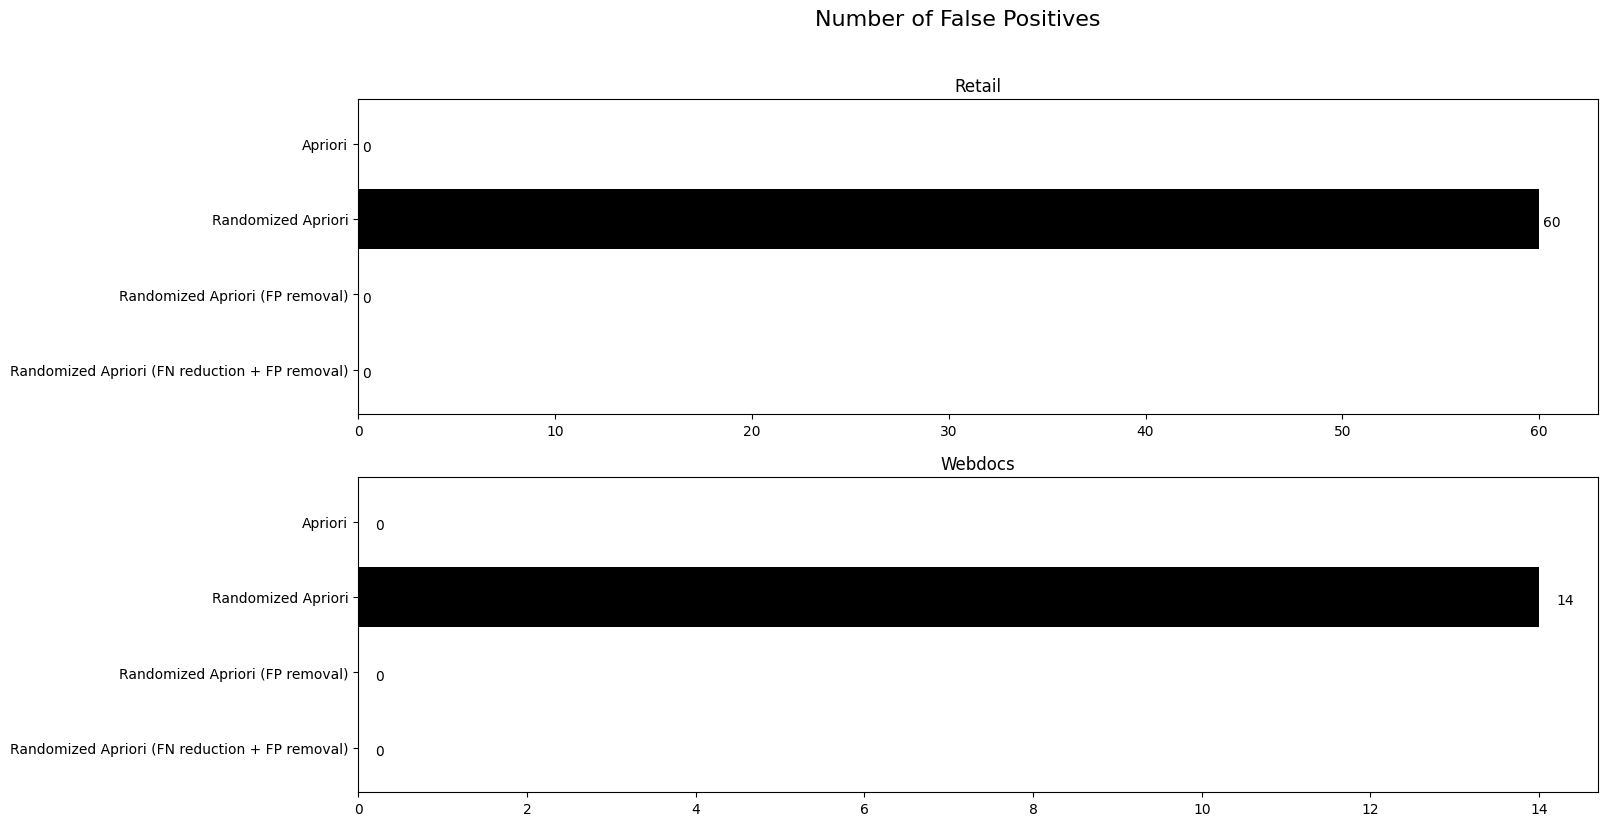

In [137]:
fig, axs = plt.subplots(2, figsize =(16, 9))
axs[0].barh(fp_df_retail['label'].to_list(), fp_df_retail[0].to_list(), color='black')
axs[1].barh(fp_df_webdocs['label'].to_list(), fp_df_webdocs[0].to_list(), color='black')

# show top values
axs[0].invert_yaxis()
axs[1].invert_yaxis()

# add annotation to bars
for ax in axs:
    for p in ax.patches:
        ax.annotate(str(round((p.get_width()), 2)), (p.get_width()+0.2, p.get_y()+0.5))
        
fig.suptitle('Number of False Positives', fontsize=16)
axs[0].set_title('Retail')
axs[1].set_title('Webdocs')
plt.show()

As we can see, the FP removal does its job.

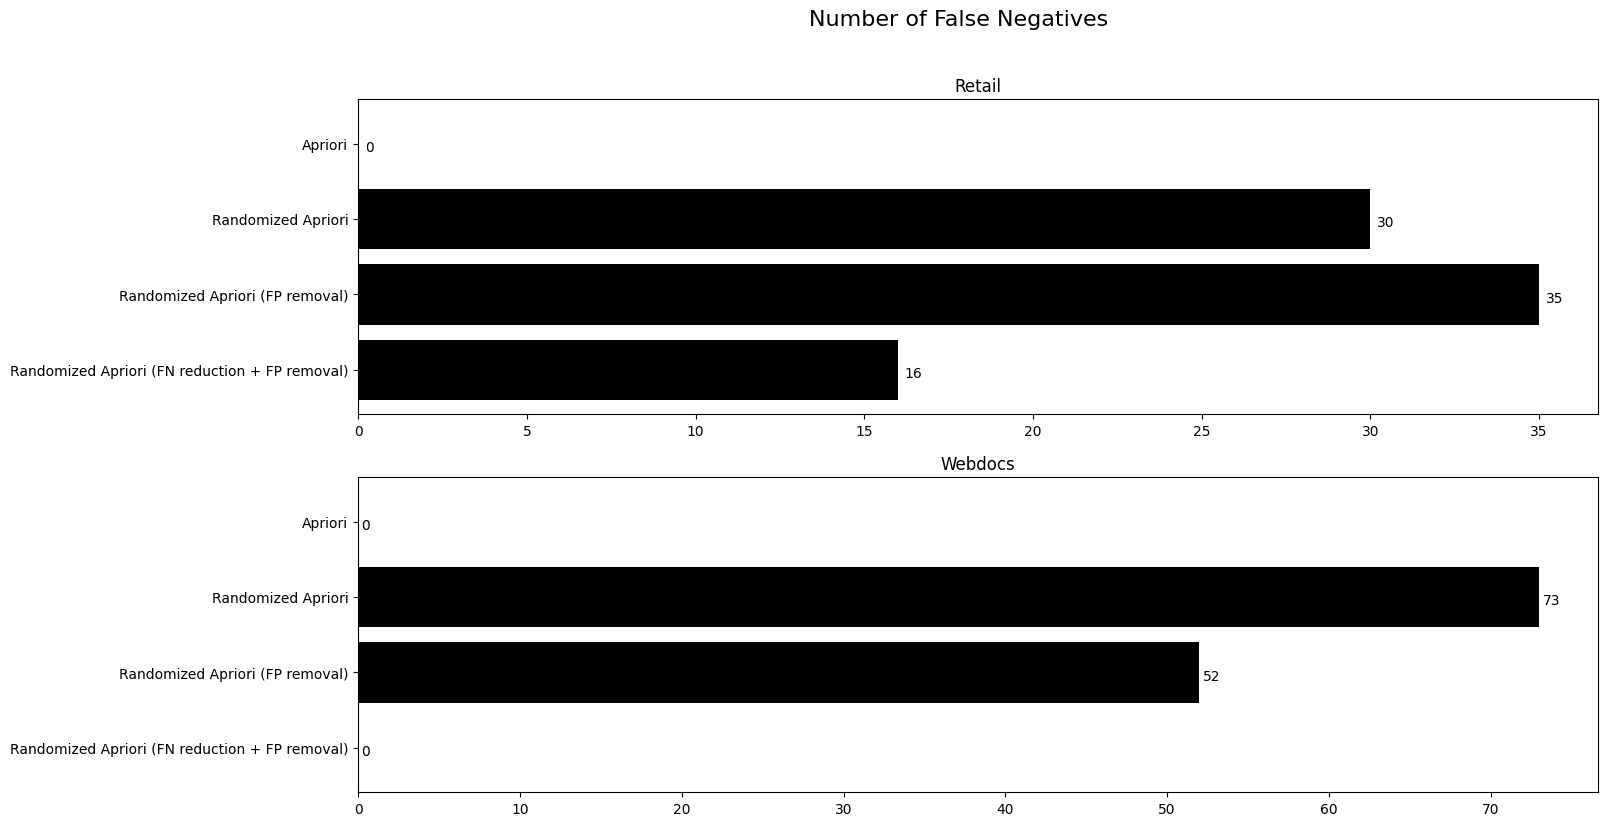

In [139]:
fig, axs = plt.subplots(2, figsize =(16, 9))
axs[0].barh(fn_df_retail['label'].to_list(), fn_df_retail[0].to_list(), color='black')
axs[1].barh(fn_df_webdocs['label'].to_list(), fn_df_webdocs[0].to_list(), color='black')

# show top values
axs[0].invert_yaxis()
axs[1].invert_yaxis()

# add annotation to bars
for ax in axs:
    for p in ax.patches:
        ax.annotate(str(round((p.get_width()), 2)), (p.get_width()+0.2, p.get_y()+0.5))
        
fig.suptitle('Number of False Negatives', fontsize=16)
axs[0].set_title('Retail')
axs[1].set_title('Webdocs')
plt.show()

As it seems, FN reduction also does what it is supposed to do.

### 3.2. Efficiency
We also compare the runtimes of the approaches. Visibly, randomized Apriori can be much faster than standard Apriori, especially for large data sets. The FP removal adds a little bit of time on top but is still fast.

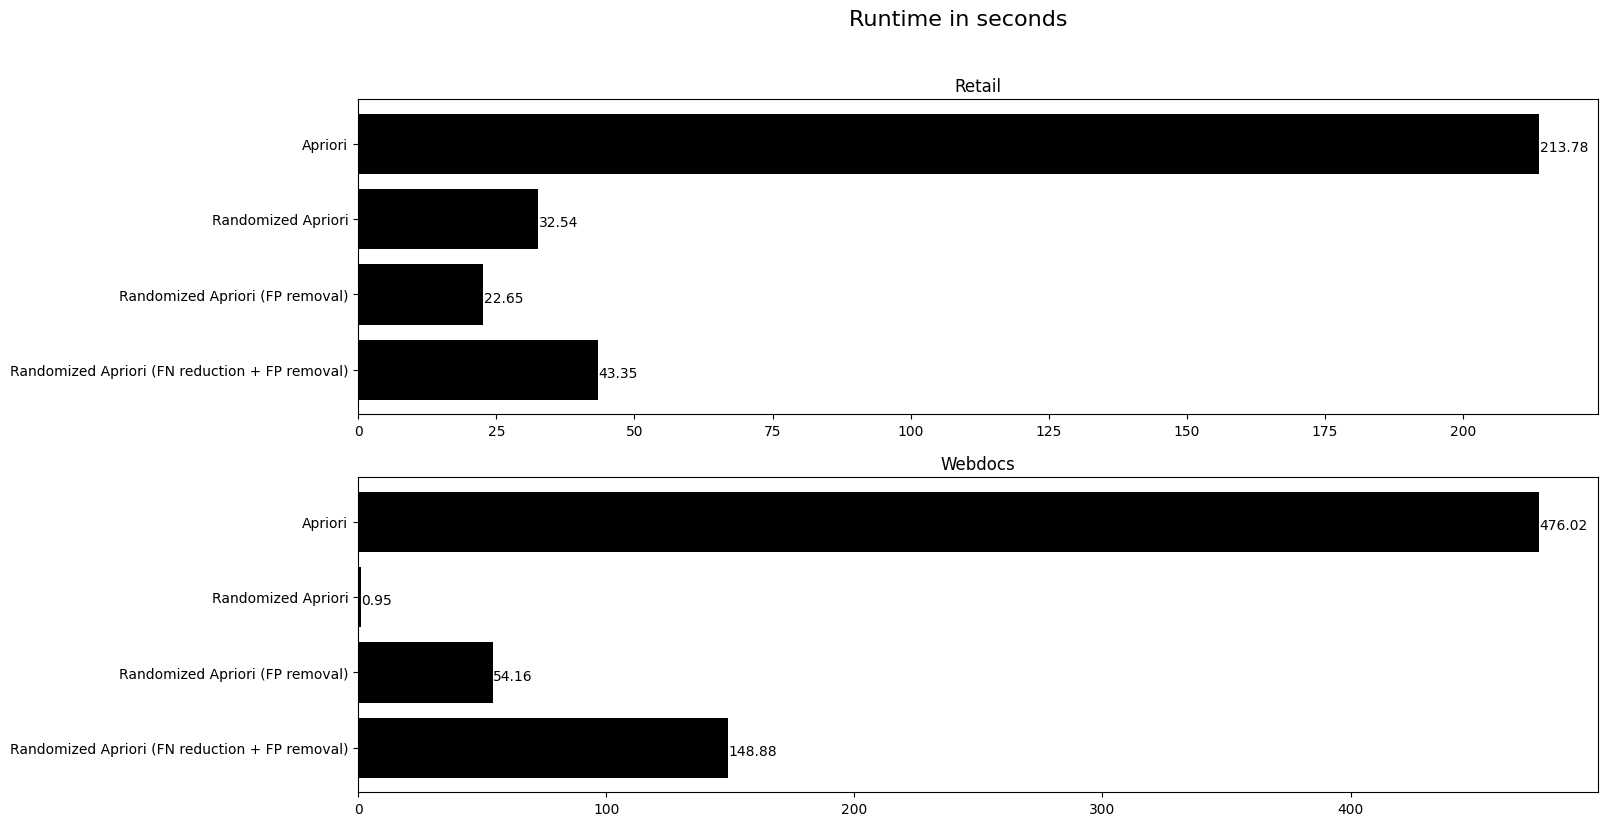

In [140]:
fig, axs = plt.subplots(2, figsize =(16, 9))
axs[0].barh(times_df_retail['label'].to_list(), times_df_retail[0].to_list(), color='black')
axs[1].barh(times_df_webdocs['label'].to_list(), times_df_webdocs[0].to_list(), color='black')

# show top values
axs[0].invert_yaxis()
axs[1].invert_yaxis()

# add annotation to bars
for ax in axs:
    for p in ax.patches:
        ax.annotate(str(round((p.get_width()), 2)), (p.get_width()+0.2, p.get_y()+0.5))
        
fig.suptitle('Runtime in seconds', fontsize=16)
axs[0].set_title('Retail')
axs[1].set_title('Webdocs')
plt.show()